# Simulating the power spectrum of fringe motion in an interferfometer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import MegaScreen
from theory import interf_spectrum_quad
import scipy.signal
np.__version__,scipy.__version__

('1.17.0', '1.3.1')

## Generate phases at each telescope

Use two windows separated perpendicular to the wind direction. Long thin windows are chained together to provide a long time series. Windows are 2 pixels wide in case there is a problem with 1-pixel wide windows, 1 line is thrown away.

In [2]:
def interferometer_phases(r0=5,L0=3000,baseline=250,step=32,numScreen=160000,):
    args=locals()
    args["MegaScreenVersion"]=MegaScreen.__version__
    g=MegaScreen.MegaScreen(r0=r0, L0=L0, windowShape=[step, 2], windowOrigins=[(0.0,0.0), (0.0, baseline)],
                 dx=step)
    phase=np.concatenate([next(g) for i in range(numScreen)],axis=1)
    return phase[:,:,0],args

In [3]:
# This may take some time...
phases,args=interferometer_phases()

## Plot the individual phases and phase differences

{'r0': 5, 'L0': 3000, 'baseline': 250, 'step': 32, 'numScreen': 160000, 'MegaScreenVersion': '0.5.0'}


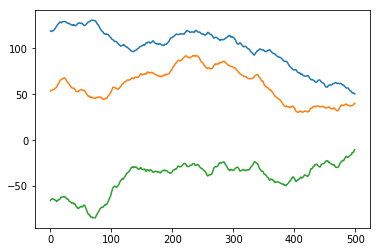

In [4]:
diff=phases[1]-phases[0]
plt.plot(phases[0][:500])
plt.plot(phases[1][:500])
plt.plot(diff[:500])
print(args)

## Plot the power spectrum of the phase difference

Compare to the theoretical spectrum for the wind perpendicular to the baseline

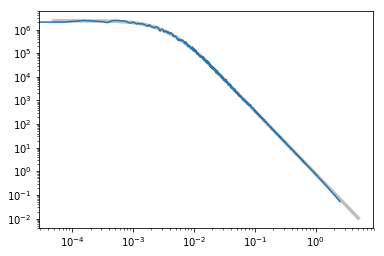

In [5]:
def logbin(x,y,unitbin):
    """
    C UNITBIN is the x-coord at which the bin size is equal to the initial
    C bin size. For samples up to this ordinate, no binning is done, and
    C after this the bin size is the nearest integer to X/UNITBIN where X is
    C the x-coord of the  leftmost initial bin.
    C
    C If last bin has less than a full complement of samples, it IS computed.
    C The number of computed bins is returned in NBIN.
    """
    i=0
    imax=len(x)
    xnew=[]
    ynew=[]
    while i<imax:
        nbin=int(max(1,x[i]/unitbin))
        nbin=min(imax-i,nbin)
        #print(nbin)
        xnew.append(np.sum(x[i:i+nbin])/nbin)
        ynew.append(np.sum(y[i:i+nbin])/nbin)
        i+=nbin
    return np.array(xnew),np.array(ynew)

def plot_spectrum(phase,args,nperseg=65536,unitbin=2e-3):
    frequency,power=scipy.signal.welch(phase,nperseg=nperseg)
    x,y=logbin(frequency[:-1],power[:-1],unitbin)
    r0=args["r0"]
    plt.loglog(x*r0,y)


def plot_theoretical(meta,fmin=1e-5,fmax=1,numpoint=100):
    f=np.logspace(np.log10(fmin),np.log10(fmax),numpoint)
    baseline=meta["baseline"]
    r0=meta["r0"]
    L0=meta["L0"]
    plt.plot(f*r0,interf_spectrum_quad(baseline,f,r0=r0,L0=L0),lw=3.5,color="0.75")

plot_theoretical(args)
plot_spectrum(diff,args)